In [198]:
'''data'''
import pandas as pd
import numpy as np
import json
import pickle

# help functions
#%run nlp_helpers.ipynb

'''features'''
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

'''classifiers'''
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier



'''metrics'''
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, roc_curve, auc, confusion_matrix
from scipy import interp
from itertools import cycle

'''plots'''
import matplotlib.pyplot as plt
import seaborn as sns

## Import data

In [2]:
contents = []
labels = []

with open("news_article_data.json", 'r') as file:
    for line in file:
        headline = json.loads(line)
        
        contents.append(headline['content'])
        labels.append(headline['annotation']['label'][0])
        
print(len(contents), len(labels))

7600 7600


In [3]:
df = pd.DataFrame(list(zip(contents, labels)), columns=["content", "label"])

In [4]:
df.head()

,content,label
0,Unions representing workers at Turner Newall...,Business
1,"SPACE.com - TORONTO, Canada -- A second\team o...",SciTech
2,AP - A company founded by a chemistry research...,SciTech
3,AP - It's barely dawn when Mike Fitzpatrick st...,SciTech
4,AP - Southern California's smog-fighting agenc...,SciTech


In [5]:
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import itertools, string, operator, re, unicodedata, nltk
from operator import itemgetter
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
from bs4 import BeautifulSoup
import numpy as np
from itertools import combinations
from gensim.models import Phrases
from collections import Counter


# -------------------------------------------------

# This function tokenize text
tokenizer = TweetTokenizer()  # choose my nltk tokenizer
def casual_tokenizer(text): #Splits words on white spaces (leaves contractions intact) and splits out trailing punctuation
    tokens = tokenizer.tokenize(text)
    return tokens


# -------------------------------------------------

#Contraction map
c_dict = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "i'd": "I would",
  "i'd've": "I would have",
  "i'll": "I will",
  "i'll've": "I will have",
  "i'm": "I am",
  "i've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

c_re = re.compile('(%s)' % '|'.join(c_dict.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return c_dict[match.group(0)]
    return c_re.sub(replace, text)




# -------------------------------------------------

lemmatizer = WordNetLemmatizer()

#Function to replace the nltk pos tags with the corresponding wordnet pos tag.  This is to be used by the wordnet lemmatizer
def get_word_net_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def lemma_wordnet(tagged_text):
    final = []
    for word, tag in tagged_text:
        wordnet_tag = get_word_net_pos(tag)
        if wordnet_tag is None:
            final.append(lemmatizer.lemmatize(word))
        else:
            final.append(lemmatizer.lemmatize(word, pos=wordnet_tag))
    return final


# -------------------------------------------------

# a list of puncutations and stopwords
punc = list(set(string.punctuation))
add_stop = ['', ' ', 'say', 's', 'u', 'ap', 'afp', '...', 'n', '\\'] # additional stopwords that I define
stop_words = ENGLISH_STOP_WORDS.union(add_stop)
  
    

# -------------------------------------------------

# The main process text function

def process_text(text):
    
    # These processing steps are really not needed unless we are dealing with html text
    soup = BeautifulSoup(text, "lxml") # parse and read text from HTML
    tags_del = soup.get_text() # get the text of the html only (so no html tags)
    no_html = re.sub('<[^>]*>', '', tags_del) # remove additional symbols from text
    
    # tokenize the each headline
    tokenized = casual_tokenizer(no_html)
    
    # take lower case of tokenized word
    lower = [item.lower() for item in tokenized]
    
    # https://devpost.com/software/contraction-expander
    # Convert things like "you've" to "you have", and "she'll" to "she will"
    decontract = [expandContractions(item, c_re=c_re) for item in lower]
    
    
    # perform part of speech tagging, I need the tag for my nltk lemmatizer
    tagged = nltk.pos_tag(decontract)
    
    #lemmatize the tokens
    lemma = lemma_wordnet(tagged)
    
    # remove digits, puncutations and stopwords  
    no_num = [re.sub('[0-9]+', '', each) for each in lemma]
    no_punc = [w for w in no_num if w not in punc]
    no_stop = [w for w in no_punc if w not in stop_words]
    
    return no_stop

C:\Users\henry_dw8mcdk\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


**Let's apply processing to a sample headline**

In [6]:
sample = df["content"][120]
print(sample)

The price of oil has continued its sharp rise overnight, closing at a record high. The main contract in New York, light sweet crude for delivery next month, has closed at a record \$US46.75 a barrel - up 70 cents on yesterday #39;s close.


In [7]:
soup = BeautifulSoup(sample, "lxml") # parse and read text from HTML
print(soup)

<html><body><p>The price of oil has continued its sharp rise overnight, closing at a record high. The main contract in New York, light sweet crude for delivery next month, has closed at a record \$US46.75 a barrel - up 70 cents on yesterday #39;s close.</p></body></html>


In [8]:
tags_del = soup.get_text() # get the text of the html only (so no html tags)
print(tags_del)

The price of oil has continued its sharp rise overnight, closing at a record high. The main contract in New York, light sweet crude for delivery next month, has closed at a record \$US46.75 a barrel - up 70 cents on yesterday #39;s close.


In [9]:
no_html = re.sub('<[^>]*>', '', tags_del) # remove additional symbols from text
print (no_html)

The price of oil has continued its sharp rise overnight, closing at a record high. The main contract in New York, light sweet crude for delivery next month, has closed at a record \$US46.75 a barrel - up 70 cents on yesterday #39;s close.


In [10]:
tokenized = casual_tokenizer(no_html) # tokenize the headline
print(tokenized)

['The', 'price', 'of', 'oil', 'has', 'continued', 'its', 'sharp', 'rise', 'overnight', ',', 'closing', 'at', 'a', 'record', 'high', '.', 'The', 'main', 'contract', 'in', 'New', 'York', ',', 'light', 'sweet', 'crude', 'for', 'delivery', 'next', 'month', ',', 'has', 'closed', 'at', 'a', 'record', '\\', '$', 'US46', '.', '75', 'a', 'barrel', '-', 'up', '70', 'cents', 'on', 'yesterday', '#39', ';', 's', 'close', '.']


In [11]:
# take lower case of each tokens
lower = [item.lower() for item in tokenized]    
print(lower)

['the', 'price', 'of', 'oil', 'has', 'continued', 'its', 'sharp', 'rise', 'overnight', ',', 'closing', 'at', 'a', 'record', 'high', '.', 'the', 'main', 'contract', 'in', 'new', 'york', ',', 'light', 'sweet', 'crude', 'for', 'delivery', 'next', 'month', ',', 'has', 'closed', 'at', 'a', 'record', '\\', '$', 'us46', '.', '75', 'a', 'barrel', '-', 'up', '70', 'cents', 'on', 'yesterday', '#39', ';', 's', 'close', '.']


In [12]:
# decontract you'll to you will
decontract = [expandContractions(item, c_re=c_re) for item in lower]
print(decontract)

['the', 'price', 'of', 'oil', 'has', 'continued', 'its', 'sharp', 'rise', 'overnight', ',', 'closing', 'at', 'a', 'record', 'high', '.', 'the', 'main', 'contract', 'in', 'new', 'york', ',', 'light', 'sweet', 'crude', 'for', 'delivery', 'next', 'month', ',', 'has', 'closed', 'at', 'a', 'record', '\\', '$', 'us46', '.', '75', 'a', 'barrel', '-', 'up', '70', 'cents', 'on', 'yesterday', '#39', ';', 's', 'close', '.']


In [13]:
# get the POS tags
tagged = nltk.pos_tag(decontract)
print(tagged)

[('the', 'DT'), ('price', 'NN'), ('of', 'IN'), ('oil', 'NN'), ('has', 'VBZ'), ('continued', 'VBN'), ('its', 'PRP$'), ('sharp', 'JJ'), ('rise', 'NN'), ('overnight', 'NN'), (',', ','), ('closing', 'VBG'), ('at', 'IN'), ('a', 'DT'), ('record', 'NN'), ('high', 'NN'), ('.', '.'), ('the', 'DT'), ('main', 'JJ'), ('contract', 'NN'), ('in', 'IN'), ('new', 'JJ'), ('york', 'NN'), (',', ','), ('light', 'JJ'), ('sweet', 'JJ'), ('crude', 'NN'), ('for', 'IN'), ('delivery', 'NN'), ('next', 'JJ'), ('month', 'NN'), (',', ','), ('has', 'VBZ'), ('closed', 'VBN'), ('at', 'IN'), ('a', 'DT'), ('record', 'NN'), ('\\', 'NNP'), ('$', '$'), ('us46', 'JJ'), ('.', '.'), ('75', 'CD'), ('a', 'DT'), ('barrel', 'NN'), ('-', ':'), ('up', 'RB'), ('70', 'CD'), ('cents', 'NNS'), ('on', 'IN'), ('yesterday', 'NN'), ('#39', 'NNP'), (';', ':'), ('s', 'VBD'), ('close', 'RB'), ('.', '.')]


In [14]:
#lemmatize the tokens
lemma = lemma_wordnet(tagged)
print(lemma)

['the', 'price', 'of', 'oil', 'have', 'continue', 'it', 'sharp', 'rise', 'overnight', ',', 'close', 'at', 'a', 'record', 'high', '.', 'the', 'main', 'contract', 'in', 'new', 'york', ',', 'light', 'sweet', 'crude', 'for', 'delivery', 'next', 'month', ',', 'have', 'close', 'at', 'a', 'record', '\\', '$', 'us46', '.', '75', 'a', 'barrel', '-', 'up', '70', 'cent', 'on', 'yesterday', '#39', ';', 's', 'close', '.']


In [15]:
# remove digits, puncutations and stopwords
no_num = [re.sub('[0-9]+', '', each) for each in lemma]
no_punc = [w for w in no_num if w not in punc]
no_stop = [w for w in no_punc if w not in stop_words]
print(no_stop)

['price', 'oil', 'continue', 'sharp', 'rise', 'overnight', 'close', 'record', 'high', 'main', 'contract', 'new', 'york', 'light', 'sweet', 'crude', 'delivery', 'month', 'close', 'record', 'barrel', 'cent', 'yesterday', 'close']


**Thoughts: I can accomplish the above tokenizing, lemmatizing and cleaning a lot easier with spaCy.**

**Apply the process_text() to all headlines in the DataFrame**

In [16]:
%%time
df['clean_text'] = df['content'].apply(lambda x: process_text(x))

Wall time: 37.8 s


In [17]:
df.head()

,content,label,clean_text
0,Unions representing workers at Turner Newall...,Business,"[union, represent, worker, turner, newall, dis..."
1,"SPACE.com - TORONTO, Canada -- A second\team o...",SciTech,"[space.com, toronto, canada, second, team, roc..."
2,AP - A company founded by a chemistry research...,SciTech,"[company, chemistry, researcher, university, l..."
3,AP - It's barely dawn when Mike Fitzpatrick st...,SciTech,"[it is, barely, dawn, mike, fitzpatrick, start..."
4,AP - Southern California's smog-fighting agenc...,SciTech,"[southern, california's, smog-fighting, agency..."


## Exploring the data

**What is the most frequent words in all of the headlines**

In [18]:
clean_text_list = df['clean_text'].tolist() # a list of list of tokens for each headline

In [19]:
# This fucntion outputs a DataFrame that contains the count of each word in the corpus
def word_freq(clean_text_list, top_n):
    flat = [item for sublist in clean_text_list for item in sublist]
    with_counts = Counter(flat)
    top = with_counts.most_common(top_n)
    word = [each[0] for each in top]
    num = [each[1] for each in top]
    return pd.DataFrame(list(zip(word, num)), columns=["words", "counts"])

In [20]:
wf = word_freq(clean_text_list, 20)
wf.head(10)

,words,counts
0,new,1077
1,reuters,793
2,year,699
3,company,590
4,quot,551
5,monday,498
6,tuesday,497
7,thursday,458
8,wednesday,447
9,win,418


**Let's see how the word_freq() works**

In [21]:
sample_clean_list = clean_text_list[:5]

In [22]:
sample_clean_list

[['union',
  'represent',
  'worker',
  'turner',
  'newall',
  'disappointed',
  'talk',
  'stricken',
  'parent',
  'firm',
  'federal',
  'mogul'],
 ['space.com',
  'toronto',
  'canada',
  'second',
  'team',
  'rocketeers',
  'compete',
  'million',
  'ansari',
  'x',
  'prize',
  'contest',
  'privately',
  'fund',
  'suborbital',
  'space',
  'flight',
  'officially',
  'announce',
  'launch',
  'date',
  'manned',
  'rocket'],
 ['company',
  'chemistry',
  'researcher',
  'university',
  'louisville',
  'win',
  'grant',
  'develop',
  'method',
  'produce',
  'good',
  'peptide',
  'short',
  'chain',
  'amino',
  'acid',
  'building',
  'block',
  'protein'],
 ['it is',
  'barely',
  'dawn',
  'mike',
  'fitzpatrick',
  'start',
  'shift',
  'blur',
  'colorful',
  'map',
  'figure',
  'endless',
  'chart',
  'know',
  'day',
  'bring',
  'lightning',
  'strike',
  'place',
  'expect',
  'wind',
  'pick',
  'moist',
  'place',
  'dry',
  'flame',
  'roar'],
 ['southern',
  "c

In [23]:
flat = [item for sublist in sample_clean_list for item in sublist] # "remove" the list of lists into one big list
print(flat)  # words can appear more than once

['union', 'represent', 'worker', 'turner', 'newall', 'disappointed', 'talk', 'stricken', 'parent', 'firm', 'federal', 'mogul', 'space.com', 'toronto', 'canada', 'second', 'team', 'rocketeers', 'compete', 'million', 'ansari', 'x', 'prize', 'contest', 'privately', 'fund', 'suborbital', 'space', 'flight', 'officially', 'announce', 'launch', 'date', 'manned', 'rocket', 'company', 'chemistry', 'researcher', 'university', 'louisville', 'win', 'grant', 'develop', 'method', 'produce', 'good', 'peptide', 'short', 'chain', 'amino', 'acid', 'building', 'block', 'protein', 'it is', 'barely', 'dawn', 'mike', 'fitzpatrick', 'start', 'shift', 'blur', 'colorful', 'map', 'figure', 'endless', 'chart', 'know', 'day', 'bring', 'lightning', 'strike', 'place', 'expect', 'wind', 'pick', 'moist', 'place', 'dry', 'flame', 'roar', 'southern', "california's", 'smog-fighting', 'agency', 'emission', 'bovine', 'variety', 'friday', 'adopt', "nation's", 'rule', 'reduce', 'air', 'pollution', 'dairy', 'cow', 'manure']


In [24]:
with_counts = Counter(flat) # input is a list, output is a Counter dict
print(with_counts)

Counter({'place': 2, 'union': 1, 'represent': 1, 'worker': 1, 'turner': 1, 'newall': 1, 'disappointed': 1, 'talk': 1, 'stricken': 1, 'parent': 1, 'firm': 1, 'federal': 1, 'mogul': 1, 'space.com': 1, 'toronto': 1, 'canada': 1, 'second': 1, 'team': 1, 'rocketeers': 1, 'compete': 1, 'million': 1, 'ansari': 1, 'x': 1, 'prize': 1, 'contest': 1, 'privately': 1, 'fund': 1, 'suborbital': 1, 'space': 1, 'flight': 1, 'officially': 1, 'announce': 1, 'launch': 1, 'date': 1, 'manned': 1, 'rocket': 1, 'company': 1, 'chemistry': 1, 'researcher': 1, 'university': 1, 'louisville': 1, 'win': 1, 'grant': 1, 'develop': 1, 'method': 1, 'produce': 1, 'good': 1, 'peptide': 1, 'short': 1, 'chain': 1, 'amino': 1, 'acid': 1, 'building': 1, 'block': 1, 'protein': 1, 'it is': 1, 'barely': 1, 'dawn': 1, 'mike': 1, 'fitzpatrick': 1, 'start': 1, 'shift': 1, 'blur': 1, 'colorful': 1, 'map': 1, 'figure': 1, 'endless': 1, 'chart': 1, 'know': 1, 'day': 1, 'bring': 1, 'lightning': 1, 'strike': 1, 'expect': 1, 'wind': 1, 

In [25]:
top = with_counts.most_common(10) # Get the top 10 words with highest count
print(top)

[('place', 2), ('union', 1), ('represent', 1), ('worker', 1), ('turner', 1), ('newall', 1), ('disappointed', 1), ('talk', 1), ('stricken', 1), ('parent', 1)]


In [26]:
word = [each[0] for each in top] # just get the wrods
print(word)

['place', 'union', 'represent', 'worker', 'turner', 'newall', 'disappointed', 'talk', 'stricken', 'parent']


In [27]:
num = [each[1] for each in top] # just get the count
print(num)

[2, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [28]:
pd.DataFrame(list(zip(word, num)))

,0,1
0,place,2
1,union,1
2,represent,1
3,worker,1
4,turner,1
5,newall,1
6,disappointed,1
7,talk,1
8,stricken,1
9,parent,1


**Average word count by category**

In [29]:
def word_count(text):
    return len(str(text).split(' '))

In [30]:
str(['Hello World, my name is Henry.']).split(' ')

["['Hello", 'World,', 'my', 'name', 'is', "Henry.']"]

In [31]:
word_count(['Hello World, my name is Henry.'])

6

In [32]:
#Avg word count by category
df['word_count'] = df['content'].apply(word_count)

In [33]:
df.head()

,content,label,clean_text,word_count
0,Unions representing workers at Turner Newall...,Business,"[union, represent, worker, turner, newall, dis...",20
1,"SPACE.com - TORONTO, Canada -- A second\team o...",SciTech,"[space.com, toronto, canada, second, team, roc...",35
2,AP - A company founded by a chemistry research...,SciTech,"[company, chemistry, researcher, university, l...",37
3,AP - It's barely dawn when Mike Fitzpatrick st...,SciTech,"[it is, barely, dawn, mike, fitzpatrick, start...",49
4,AP - Southern California's smog-fighting agenc...,SciTech,"[southern, california's, smog-fighting, agency...",27


In [34]:
avg_wc = df.groupby('label').mean().reset_index()
avg_wc

,label,word_count
0,Business,31.363684
1,SciTech,30.770000
2,Sports,31.348947
3,World,31.735789


**Preparing the dataframes**

In [35]:
#Splitting the df into the different categories
df_business = df.loc[df['label'] == 'Business'] 
df_sports = df.loc[df['label'] =='Sports']
df_scitech = df.loc[df['label'] == 'SciTech'] 
df_world = df.loc[df['label'] =='World']

In [36]:
df_business.head(5)

,content,label,clean_text,word_count
0,Unions representing workers at Turner Newall...,Business,"[union, represent, worker, turner, newall, dis...",20
41,Reuters - Apparel retailers are hoping their\b...,Business,"[reuters, apparel, retailer, hop, back-to-scho...",35
54,LONDON (Reuters) - The dollar dipped to a four...,Business,"[london, reuters, dollar, dip, four-week, low,...",44
58,NEW YORK (Reuters) - U.S. Treasury debt prices...,Business,"[new, york, reuters, treasury, debt, price, sl...",27
59,NEW YORK (Reuters) - The dollar extended gains...,Business,"[new, york, reuters, dollar, extend, gain, eur...",41


In [37]:
df_sports.head(5)

,content,label,clean_text,word_count
26,Michael Phelps won the gold medal in the 400 i...,Sports,"[michael, phelps, win, gold, medal, individual...",24
27,FOXBOROUGH -- Looking at his ridiculously deve...,Sports,"[foxborough, look, ridiculously, develop, uppe...",61
28,With the weeks dwindling until Jason Varitek e...,Sports,"[week, dwindle, jason, varitek, enters, free, ...",61
29,Just imagine what David Ortiz could do on a go...,Sports,"[just, imagine, david, ortiz, good, night's, r...",61
30,"In quot;helping themselves, quot; Ricky Bryan...",Sports,"[quot, help, quot, ricky, bryant, chas, gessne...",32


In [38]:
df_business.shape, df_scitech.shape, df_sports.shape, df_world.shape

((1900, 4), (1900, 4), (1900, 4), (1900, 4))

In [39]:
# Randomly sampling business and sports to "create" imbalanced classes  
# artifcially reduce df_business and df_sports headlines so that the classes in the dataset has imbalanced class
df_business = df_business.sample(n=1005, random_state=3)
df_sports = df_sports.sample(n=805, random_state=3)

In [40]:
#Holding out 5 articles from each class for prediction at the end (since I have no Golden Dataset)
df_business_holdout = df_business.iloc[:5]
df_sports_holdout = df_sports.iloc[:5]
df_scitech_holdout = df_scitech.iloc[:5]
df_world_holdout = df_world.iloc[:5]

In [41]:
df_business = df_business.iloc[5:]
df_sports = df_sports.iloc[5:]
df_scitech = df_scitech.iloc[5:]
df_world = df_world.iloc[5:]

In [42]:
# take out also the first 5 headlines (not sure why)
df_business = df_business.iloc[5:]
df_sports = df_sports.iloc[5:]
df_scitech = df_scitech.iloc[5:]
df_world = df_world.iloc[5:]

df_business.shape, df_sports.shape, df_scitech.shape, df_world.shape 

((995, 4), (795, 4), (1890, 4), (1890, 4))

In [43]:
# Appending the dfs back together.  The df has imbalance class now
df = pd.concat([df_business, df_sports, df_scitech, df_world])
df_holdout = pd.concat([df_business_holdout, df_sports_holdout, df_scitech_holdout, df_world_holdout])

In [44]:
#Encode the labels into numbers
le = LabelEncoder()
df['label_num'] = le.fit_transform(df['label'])

In [45]:
df.sample(5)

,content,label,clean_text,word_count,label_num
4510,Shares of Delta Air Lines soared after the tro...,Business,"[share, delta, air, line, soar, troubled, airl...",25,0
6098,"AH Jaffor Ullah. Yasser Arafat, the acknowledg...",World,"[ah, jaffor, ullah, yasser, arafat, acknowledg...",39,3
4201,Ten years after it unveiled its first dream ho...,SciTech,"[year, unveil, dream, house, microsoft, new, d...",28,1
860,At least seven people have been killed in a bo...,World,"[seven, people, kill, bomb, blast, central, ka...",24,3
6787,TiVo Inc. pioneered digital video recording as...,SciTech,"[tivo, pioneered, digital, video, record, new,...",28,1


In [46]:
display(df.groupby(['label'])['content'].count())

label
Business     995
SciTech     1890
Sports       795
World       1890
Name: content, dtype: int64

In [47]:
display(df_holdout.groupby(['label'])['content'].count())

label
Business    5
SciTech     5
Sports      5
World       5
Name: content, dtype: int64

In [48]:
display(df['label'].unique())
display(df['label_num'].unique())

array(['Business', 'Sports', 'SciTech', 'World'], dtype=object)

array([0, 2, 1, 3], dtype=int64)

In [49]:
# Top 15 words by category, now we take bigrarms into account
top_n = 15
text_bus = df_business['clean_text'].tolist()
text_sci_t = df_scitech['clean_text'].tolist()
text_sports = df_sports['clean_text'].tolist()
text_world = df_world['clean_text'].tolist()

In [50]:
# Use the word_freq_bigrams() function to transform text with bigram
def word_freq_bigrams(clean_text_list, top_n):
    
    # train gensim bigram model and use it to transform clean_text
    bigram_model = Phrases(clean_text_list, min_count=2, threshold=1)
    w_bigrams = list(bigram_model[clean_text_list])
    
    # repeat the same processing in word_freq
    flat_w_bigrams = [item for sublist in w_bigrams for item in sublist]
    with_counts = Counter(flat_w_bigrams)
    top = with_counts.most_common(top_n)
    word = [each[0] for each in top]
    num = [each[1] for each in top]
    return pd.DataFrame([word, num]).T

In [51]:
bus = word_freq_bigrams(text_bus, top_n=top_n)
sci_t = word_freq_bigrams(text_sci_t, top_n=top_n)
sports = word_freq_bigrams(text_sports, top_n=top_n)
world = word_freq_bigrams(text_world, top_n=top_n)

In [52]:
bus.head()

,0,1
0,company,124
1,new_york,111
2,year,90
3,reuters,80
4,tuesday,75


In [53]:
sci_t.head()

,0,1
0,new,184
1,company,179
2,quot,132
3,software,123
4,technology,105


In [54]:
df_wf = pd.concat([bus, sci_t, sports, world], axis=1)
cols = ['business', 'count', 'sci tech', 'count', 'sports', 'count', 'world', 'count']
df_wf.columns = cols
df_wf

,business,count,sci tech,count,sports,count,world,count
0,company,124,new,184,win,102,monday,129
1,new_york,111,company,179,game,95,reuters,119
2,year,90,quot,132,team,78,tuesday,118
3,reuters,80,software,123,season,67,friday,116
4,tuesday,75,technology,105,victory,57,iraq,115
5,wednesday,72,microsoft,104,play,56,official,105
6,new,66,make,103,year,54,quot,105
7,share,63,use,101,sunday,53,wednesday,105
8,thursday,63,service,100,run,44,country,103
9,report,59,reuters,99,new_york,44,leader,102


In [55]:
# Get bigrams and their frequency in each class
def bigram_freq(clean_text_list, top_n):
    # Train bigram model
    bigram_model = Phrases(clean_text_list, min_count=2, threshold=1)
    # transform the clean text
    w_bigrams = list(bigram_model[clean_text_list])
    
    # get a large list of all tokens
    flat_w_bigrams = [item for sublist in w_bigrams for item in sublist]
    # init a list of bigrarms
    bigrams = []
    
    # look at each token in my corpus
    for token in flat_w_bigrams:
        if '_' in token: # a bigrarm always has '_', for example "happy_hour"
            bigrams.append(token)
    counts = Counter(bigrams) # count the number of bigrams
    top = counts.most_common(top_n)
    word = [each[0] for each in top]
    num = [each[1] for each in top]
    return pd.DataFrame([word, num]).T

In [56]:
# Top 15 bigrams by category
bus_bigrams = bigram_freq(text_bus, top_n = top_n)
sci_t_bigrams = bigram_freq(text_sci_t, top_n = top_n)
sports_bigrams = bigram_freq(text_sports, top_n = top_n)
world_bigrams = bigram_freq(text_world, top_n = top_n)

In [57]:
bus_bigrams

,0,1
0,new_york,111
1,oil_price,39
2,wall_street,32
3,chief_executive,30
4,quote_profile,27
5,united_state,22
6,london_reuters,18
7,san_francisco,17
8,crude_oil,16
9,chicago_reuters,15


In [58]:
df_bigram_wf = pd.concat([bus_bigrams, sci_t_bigrams, sports_bigrams, world_bigrams], axis=1)
df_bigram_wf.columns = cols
df_bigram_wf

,business,count,sci tech,count,sports,count,world,count
0,new_york,111,microsoft_corp,47,new_york,44,prime_minister,88
1,oil_price,39,mobile_phone,41,sport_network,29,president_bush,58
2,wall_street,32,san_francisco,29,world_cup,19,united_nation,55
3,chief_executive,30,new_york,28,champion_league,18,united_state,47
4,quote_profile,27,video_game,28,red_sox,16,yasser_arafat,37
5,united_state,22,search_engine,27,st_louis,16,presidential_election,36
6,london_reuters,18,apple_computer,23,boston_red,15,kill_people,35
7,san_francisco,17,year_ago,19,united_state,13,new_york,34
8,crude_oil,16,sun_microsystems,19,los_angeles,12,north_korea,33
9,chicago_reuters,15,united_state,19,ryder_cup,12,canadian_press,28


In [59]:
df_business.head()

,content,label,clean_text,word_count
5470,Two dozen protesters greeted Mayor Tony Willia...,Business,"[dozen, protester, greet, mayor, tony, william...",23
1396,The CEO of Molson Inc. raised doubts about his...,Business,"[ceo, molson, raise, doubt, company, deal, ado...",39
2672,"Reuters - Pepsi Bottling Group Inc. , the\larg...",Business,"[reuters, pepsi, bottle, group, large, bottler...",26
6180,In these times of financial wrongdoing and sub...,Business,"[time, financial, wrongdoing, subsequent, syst...",23
6862,The U.S. dollar fell to another new low agains...,Business,"[dollar, fell, new, low, euro, friday, push, e...",28


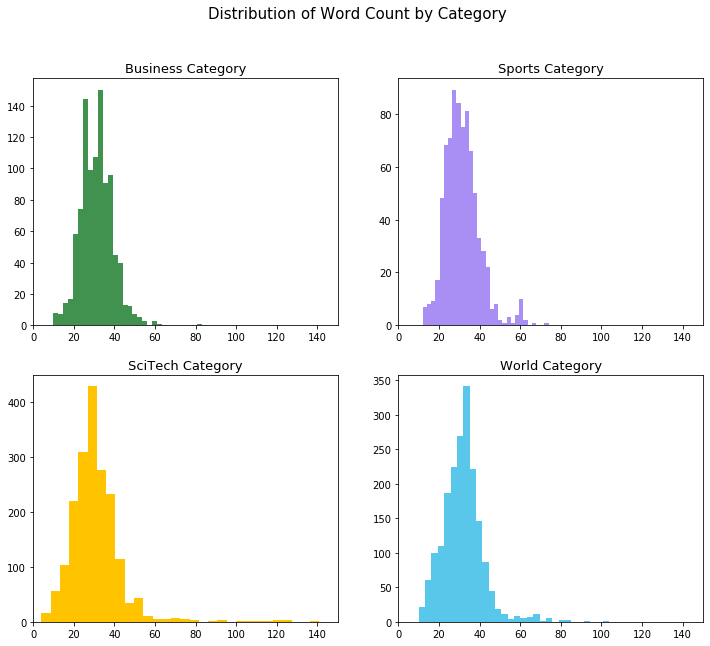

In [60]:
#Plot the distribution of word count by headline

fig, ax = plt.subplots(2, 2, figsize = (12,10)) # 4 subplots, one for each class
fig.suptitle('Distribution of Word Count by Category', fontsize=15) # super title

bins = 30

ax[0, 0].hist(df_business['word_count'], bins = bins, color = '#41924F')
ax[0, 0].set_title('Business Category', fontsize = 13)
ax[0, 0].set_xlim(0, 150)

ax[1, 0].hist(df_scitech['word_count'], bins = bins, color = '#FFC300')
ax[1, 0].set_title('SciTech Category', fontsize = 13)
ax[1, 0].set_xlim(0, 150)

ax[0, 1].hist(df_sports['word_count'], bins = bins, color = '#a98ff3')
ax[0, 1].set_title('Sports Category', fontsize = 13)
ax[0, 1].set_xlim(0, 150)

ax[1, 1].hist(df_world['word_count'], bins = bins, color = '#59C7EA')
ax[1, 1].set_title('World Category', fontsize = 13)
ax[1, 1].set_xlim(0, 150)

plt.show()

- Expected word count is About 30 words in each headline for each class
- A few really long headlines for sports
- Normally distributed, slightly right skewed

## Represent headlines with tf-idf vectors

In [61]:
df.head()

,content,label,clean_text,word_count,label_num
5470,Two dozen protesters greeted Mayor Tony Willia...,Business,"[dozen, protester, greet, mayor, tony, william...",23,0
1396,The CEO of Molson Inc. raised doubts about his...,Business,"[ceo, molson, raise, doubt, company, deal, ado...",39,0
2672,"Reuters - Pepsi Bottling Group Inc. , the\larg...",Business,"[reuters, pepsi, bottle, group, large, bottler...",26,0
6180,In these times of financial wrongdoing and sub...,Business,"[time, financial, wrongdoing, subsequent, syst...",23,0
6862,The U.S. dollar fell to another new low agains...,Business,"[dollar, fell, new, low, euro, friday, push, e...",28,0


In [62]:
# Creating the features (tf-idf weights) for the processed text
texts = df['clean_text']

In [63]:
texts

5470    [dozen, protester, greet, mayor, tony, william...
1396    [ceo, molson, raise, doubt, company, deal, ado...
2672    [reuters, pepsi, bottle, group, large, bottler...
6180    [time, financial, wrongdoing, subsequent, syst...
6862    [dollar, fell, new, low, euro, friday, push, e...
                              ...                        
7585    [billion, drug, industry, stumble, badly, core...
7591    [canadian, press, banja, luka, bosnia-herzegov...
7592    [european, union's, decision, hold, entry, tal...
7594    [washington, outgo, secretary, state, colin, l...
7595    [ukrainian, presidential, candidate, viktor, y...
Name: clean_text, Length: 5570, dtype: object

In [64]:
texts.shape

(5570,)

In [65]:
type(texts)

pandas.core.series.Series

In [66]:
texts = texts.astype('str') # convert from list to str

In [67]:
texts

5470    ['dozen', 'protester', 'greet', 'mayor', 'tony...
1396    ['ceo', 'molson', 'raise', 'doubt', 'company',...
2672    ['reuters', 'pepsi', 'bottle', 'group', 'large...
6180    ['time', 'financial', 'wrongdoing', 'subsequen...
6862    ['dollar', 'fell', 'new', 'low', 'euro', 'frid...
                              ...                        
7585    ['billion', 'drug', 'industry', 'stumble', 'ba...
7591    ['canadian', 'press', 'banja', 'luka', 'bosnia...
7592    ['european', "union's", 'decision', 'hold', 'e...
7594    ['washington', 'outgo', 'secretary', 'state', ...
7595    ['ukrainian', 'presidential', 'candidate', 'vi...
Name: clean_text, Length: 5570, dtype: object

In [68]:
# Init the tf-idf vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

In [69]:
# Train the tf-idf vectorizer and fit to the clean texts (a series of a list of strings)
# I will use the tf-idf representation of headlines as my features

X = tfidf_vectorizer.fit_transform(texts)

In [70]:
X.shape

(5570, 15095)

In [71]:
X

<5570x15095 sparse matrix of type '<class 'numpy.float64'>'
	with 116508 stored elements in Compressed Sparse Row format>

In [72]:
# The response variable is the label_nums
y = df['label_num'].values 
y

array([0, 0, 0, ..., 3, 3, 3])

In [73]:
# Use TruncatedSVD to perform dimensionality reduction-- I only use 100 features instead of 15053

# Init the TruncatedSVD model
#Dimenionality reduction. Only using the 100 best features er category
lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

X = lsa.fit_transform(X)
X.shape

(5570, 100)

In [74]:
X

array([[ 0.0542253 ,  0.0162396 ,  0.00784363, ...,  0.01205632,
        -0.03939137, -0.02318441],
       [ 0.0787592 , -0.01858469,  0.12446453, ...,  0.00664744,
        -0.00224369, -0.00602344],
       [ 0.09916859, -0.00132683, -0.06242924, ..., -0.02186757,
        -0.00705983, -0.03957862],
       ...,
       [ 0.06361298,  0.03830982,  0.01214506, ...,  0.02226893,
         0.02394338,  0.00766128],
       [ 0.11943466,  0.11599238,  0.01916947, ..., -0.02405913,
        -0.03886613, -0.0638558 ],
       [ 0.03700385,  0.03025244, -0.00017581, ..., -0.08027851,
        -0.00124353,  0.01926451]])

**At this point, I will perform train_test split, modelling, and optimization as I would do with numeric data**

**Aside, dict.itmes() in Python**

In [75]:
test = {'A':1, 'B':3, 'C': 5}

In [80]:
test.items() # a list of tuples of the key and value of my dict

dict_items([('A', 1), ('B', 3), ('C', 5)])

## Modelling

**Train-test split**

In [87]:
# Train test split with stratified sampling for evaluation
# Ensure that each class have the same proportion of sample with stratify = y 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 10)

**Modelling**

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier


In [91]:
models = {'Stochastic Gradient Descent' : SGDClassifier(random_state=10, loss='log'),
          'KNN': KNeighborsClassifier(),
          'Gaussian Naive Bayes': GaussianNB(),
          'Random Forest': RandomForestClassifier(random_state=10),
          'AdaBoost': AdaBoostClassifier(random_state=10)}

In [103]:
# Function to get the scores for each model in a df
def model_score(model_dict):   
    model_name, acc_score_list, precision_score_list, recall_score_list, f1_score_list = [], [], [], [], []
    
    for k,v in model_dict.items():   
        
        model_name.append(k)
        
        # Train model and make predictions
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        
        # Model performance
        acc_score_list.append(accuracy_score(y_test, y_pred))
        # compute precision of each class and take average
        precision_score_list.append(precision_score(y_test, y_pred, average='macro')) 
        recall_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        
        # Organize metrics for each model in a DataFrame
        model_comparison_df = pd.DataFrame(list(zip(model_name, acc_score_list, precision_score_list, 
                                            recall_score_list, f1_score_list)), 
                                            columns= ['model_name', 'accuracy_score', 'precision_score', 
                                                      'recall_score', 'f1_score'])
        # sort by f1_score
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
   
    return model_comparison_df

In [104]:
model_score(models)

,model_name,accuracy_score,precision_score,recall_score,f1_score
3,Random Forest,0.806104,0.803119,0.781084,0.790546
0,Stochastic Gradient Descent,0.812089,0.823548,0.765622,0.785545
4,AdaBoost,0.753441,0.749890,0.745865,0.746634
1,KNN,0.739677,0.735836,0.722765,0.725257
2,Gaussian Naive Bayes,0.675045,0.666581,0.685847,0.655649


## Model Optimization
- I will pick the top 2 models: Random Froest, and SGD to optimize.

In [123]:
# A dict with model name and object
models = {'SGD': SGDClassifier(loss = 'log'),
          'RandomForestClassifier': RandomForestClassifier(min_samples_leaf=1, max_features='auto')}

In [125]:
# Use a dictionary of dictionaries to set grid params for logreg and rf
params = {
    'SGD':  {
        "penalty": ['l2', 'l1'],
        "alpha":  [1e-6, 1e-3, 1e-1, 1e0],
        "max_iter":  [5, 1000, 5000],
        "eta0": [0.1, 0.001]
        },
    
    'RandomForestClassifier':  { 
        "n_estimators" : [1400, 1500],
        "max_depth"    : [10,50],
        "min_samples_split": [5,10]
    }

}

**GridSearchCV**

In [152]:
from sklearn.model_selection import GridSearchCV

In [153]:
def fit_assess(X_train, y_train):
    """ 
    Fit a list of models with the training data one at a time and obtain 
    models with the best parameters (have the lowest test error from CV)
    """
    best_estimators = [] # a list of "best" estimators: a best SVD, a best rf and a best adb
    
    for name in models.keys():
        est = models[name]  # initial model object
        est_params = params[name] # parameters for the model
        gscv = GridSearchCV(estimator=est, 
                            param_grid=est_params, 
                            cv=5,
                            verbose = 2,
                            n_jobs=-1)  #GridSearchCV model
        gscv.fit(X_train, y_train)
        print("The best parameters are: {}".format(gscv.best_params_))
        
        # a list of estimator with the "best" parameters that result in the highest test accuracy
        best_estimators.append(gscv) 

    return best_estimators

In [154]:
execute = True
if execute:
    best_models=fit_assess(X_train,y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   24.6s finished


The best parameters are: {'alpha': 1e-06, 'eta0': 0.001, 'max_iter': 5000, 'penalty': 'l2'}
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 10.1min finished


The best parameters are: {'max_depth': 50, 'min_samples_split': 5, 'n_estimators': 1400}


In [155]:
# save the best models to disk
pickle.dump(best_models[0], open('saved_models/best_sgd_model.sav', 'wb'))
pickle.dump(best_models[1], open('saved_models/best_rf_model.sav', 'wb'))

In [156]:
# load the model from disk
best_models[0] = pickle.load(open('saved_models/best_sgd_model.sav', 'rb'))
best_models[1] = pickle.load(open('saved_models/best_rf_model.sav', 'rb'))

**Armed with the optimized models from GridSearchCV, I can choose the "best" statistical learning approach based on highest AUC score (on the test dataset)**

In [163]:
best_f1=0
best_gs = ''

for i, gs in enumerate(best_models):
    
    # Get best parameters
    print("\n")
    print(list(models.keys())[i])
    print("Best parameters are: {}".format(gs.best_params_))
    
    # Get best score (from CV)
    print("Best estimated test accuracy (from CV): {}".format(gs.best_score_))
    
    # test predictions 
    y_pred = gs.predict(X_test)
    
    print("The f1 score of the model with the best parameters (on the test dataset): {}".format(f1_score(y_test,y_pred,
                                                                                                        average='macro')))
    
    # Get the best statistical learning approach
    if f1_score(y_test,y_pred, average = 'macro') >= best_f1:
        best_f1 = f1_score(y_test,y_pred, average='macro')  # update best f1 score
        best_gs = gs  # update the best statistical learning approach
        best_clf_index = i
        

print("\n The best statistical learning approach (on the test dataset) is {}".format(list(models.keys())[best_clf_index]))



SGD
Best parameters are: {'alpha': 1e-06, 'eta0': 0.001, 'max_iter': 5000, 'penalty': 'l2'}
Best estimated test accuracy (from CV): 0.8107228201836675
The f1 score of the model with the best parameters (on the test dataset): 0.8078031056594472


RandomForestClassifier
Best parameters are: {'max_depth': 50, 'min_samples_split': 5, 'n_estimators': 1400}
Best estimated test accuracy (from CV): 0.8158480629340706
The f1 score of the model with the best parameters (on the test dataset): 0.7968010416846764

 The best statistical learning approach (on the test dataset) is SGD


## Plot AUC- SGD

In [167]:
#Plot AUC - SGD

#Binarize the labels
y_b = label_binarize(y, classes = [0, 1, 2, 3])
n_classes = y_b.shape[1] # y is now an array of array

In [168]:
y_b

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1]])

In [171]:
y_b.shape

(5570, 4)

In [172]:
#Shuffle and split training and test sets with stratified sampling and binarized labels
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X, y_b,
                                                            test_size = 0.3,
                                                            shuffle = True,
                                                            stratify = y,
                                                            random_state = 10)


In [174]:
from sklearn.multiclass import OneVsRestClassifier

In [176]:
#Learn to predict each class against the other
sgd_classifier = OneVsRestClassifier(best_models[0].best_estimator_)
# Train the model with the best parameters
sgd_classifier.fit(X_train_b, y_train_b)

OneVsRestClassifier(estimator=SGDClassifier(alpha=1e-06, average=False,
                                            class_weight=None,
                                            early_stopping=False, epsilon=0.1,
                                            eta0=0.001, fit_intercept=True,
                                            l1_ratio=0.15,
                                            learning_rate='optimal', loss='log',
                                            max_iter=5000, n_iter_no_change=5,
                                            n_jobs=None, penalty='l2',
                                            power_t=0.5, random_state=None,
                                            shuffle=True, tol=0.001,
                                            validation_fraction=0.1, verbose=0,
                                            warm_start=False),
                    n_jobs=None)

In [181]:
# Get the z-score (proba) of each class
z_score = sgd_classifier.predict_proba(X_test_b)

In [182]:
z_score

array([[4.56378920e-01, 2.16250702e-02, 1.53676715e-01, 6.93932199e-03],
       [2.28715741e-03, 9.99912363e-01, 9.47295335e-06, 4.02738193e-07],
       [1.04662867e-01, 5.45692497e-02, 1.97296196e-02, 5.54287502e-01],
       ...,
       [3.00515915e-01, 9.13014068e-01, 4.55240948e-07, 4.40980679e-03],
       [2.76347823e-03, 9.99602385e-01, 4.18482286e-04, 1.67610459e-03],
       [1.29949312e-03, 9.99595976e-01, 2.51235749e-03, 2.05754014e-03]])

In [184]:
#C ompute ROC curve and ROC area for EACH class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes): 
    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], z_score[:, i]) # get fpr and tpr one class at a time
    roc_auc[i] = auc(fpr[i], tpr[i])

In [185]:
fpr

{0: array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.28332119e-04,
        7.28332119e-04, 1.45666424e-03, 1.45666424e-03, 2.18499636e-03,
        2.18499636e-03, 2.91332848e-03, 2.91332848e-03, 5.82665696e-03,
        5.82665696e-03, 7.28332119e-03, 7.28332119e-03, 8.73998543e-03,
        8.73998543e-03, 1.09249818e-02, 1.09249818e-02, 1.16533139e-02,
        1.16533139e-02, 1.23816460e-02, 1.23816460e-02, 1.31099782e-02,
        1.31099782e-02, 1.38383103e-02, 1.38383103e-02, 1.45666424e-02,
        1.45666424e-02, 1.52949745e-02, 1.52949745e-02, 1.60233066e-02,
        1.60233066e-02, 1.67516387e-02, 1.67516387e-02, 1.74799709e-02,
        1.74799709e-02, 2.03932993e-02, 2.03932993e-02, 2.11216315e-02,
        2.11216315e-02, 2.25782957e-02, 2.25782957e-02, 2.33066278e-02,
        2.33066278e-02, 2.54916242e-02, 2.54916242e-02, 2.62199563e-02,
        2.62199563e-02, 2.76766205e-02, 2.76766205e-02, 2.91332848e-02,
        2.91332848e-02, 2.98616169e-02, 2.98616169e-02, 3.058

In [191]:
# Compute micro-average ROC curve and ROC area
fpr['micro'], tpr['micro'], _ = roc_curve(y_test_b.ravel(), z_score.ravel()) 
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

In [190]:
y_test_b.shape

(1671, 4)

In [189]:
y_test_b.ravel().shape

(6684,)

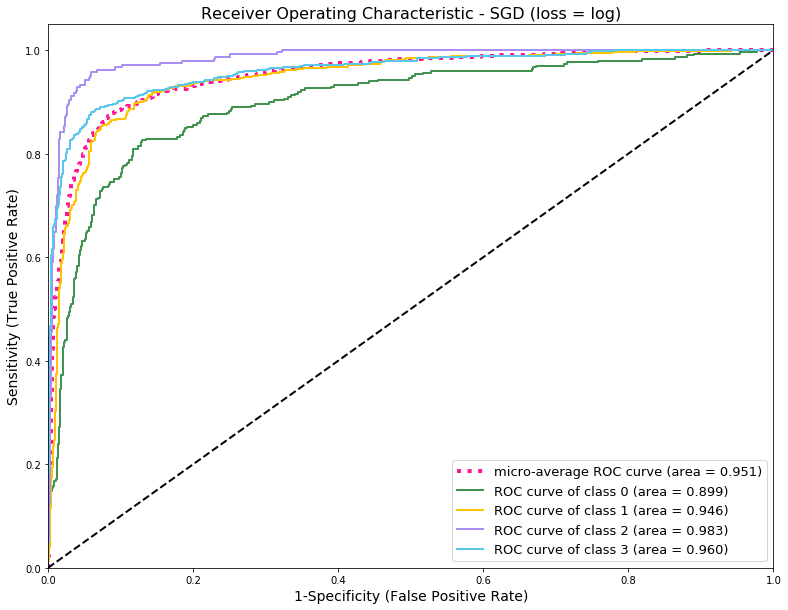

In [193]:
#Plot all ROC curves
plt.figure(figsize=(13,10)) 
lw=2

plt.plot(fpr['micro'], 
         tpr['micro'], 
         label='micro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['micro']),
         color='deeppink',
         linestyle=':', 
         linewidth=4)


colors = cycle(['#41924F', '#FFC300', '#a98ff3', '#59C7EA'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], 
             color=color, 
             lw=lw, 
             label='ROC curve of class {0} (area = {1:0.3f})'''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity (False Positive Rate)', fontsize = 14)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize = 14)
plt.title('Receiver Operating Characteristic - SGD (loss = log)', fontsize = 16)
plt.legend(loc="lower right", fontsize = 13)
plt.show()

## Confusion Matrix for SGD

In [200]:
#Train test split with stratified sampling. Using non-binarized labels
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.3, 
                                                    shuffle = True, 
                                                    stratify = y, 
                                                    random_state = 10)
#Fit the training data
sgd_classifier.fit(X_train, y_train)
#Predict the testing data
y_pred = sgd_classifier.predict(X_test)

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred) 
cm

array([[162,  65,   2,  69],
       [ 30, 484,   3,  50],
       [  4,  15, 172,  48],
       [ 14,  19,   9, 525]], dtype=int64)

In [201]:
cm_df = pd.DataFrame(cm,
                     index = ['business','scitech','sports', 'world'], 
                     columns = ['business','scitech','sports', 'world'])


In [203]:
cm_df

,business,scitech,sports,world
business,162,65,2,69
scitech,30,484,3,50
sports,4,15,172,48
world,14,19,9,525


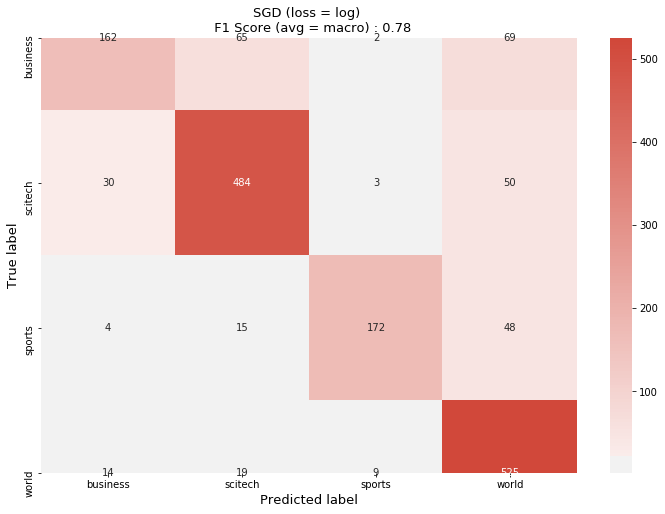

In [204]:
#Plot the heatmap
plt.figure(figsize=(12, 8))

sns.heatmap(cm_df, 
            center=0, 
            cmap=sns.diverging_palette(220, 15, as_cmap=True), 
            annot=True, 
            fmt='g')

plt.title('SGD (loss = log) \n  F1 Score (avg = macro) : {0:.2f}'.format(f1_score(y_test, y_pred, average='macro')), fontsize = 13)
plt.ylabel('True label', fontsize = 13)
plt.xlabel('Predicted label', fontsize = 13)
plt.show()

## Take a look at the predictions for the 5 holdout headlines

In [205]:
hold_out = df_holdout['clean_text'].astype('str')

In [211]:
hold_out # 5 headlines from each class (20 headlines in total)

5051    ['ve', 'airplane', 'abort', 'landing', 'know',...
6272    ['new', 'york', 'reuters', 'stock', 'rise', 'm...
3341    ['stock', 'look', 'open', 'flat', 'thursday', ...
6067    ['united', 'state', 'australia', 'prevail', 'i...
4673    ['new', 'york', 'reuters', 'stock', 'jump', 'w...
4848    ['vienna', 'reuters', 'seed', 'amelie', 'maure...
6232    ['feyenoord', 'bos', 'ruud', 'gullit', 'launch...
3072    ['jim', 'mora', 'think', 'team', 'deserve', 'l...
6007    ['motorsport.com', 'report', 'week', 'suggest'...
4431    ['race', 'fan', 'wave', 'american', 'flag', 's...
1       ['space.com', 'toronto', 'canada', 'second', '...
2       ['company', 'chemistry', 'researcher', 'univer...
3       ['it is', 'barely', 'dawn', 'mike', 'fitzpatri...
4       ['southern', "california's", 'smog-fighting', ...
5       ['british', 'department', 'education', 'skill'...
32      ['canadian', 'press', 'vancouver', 'cp', 'sist...
33      ['man', 'claim', 'gov', 'james', 'e', 'mcgreev...
34      ['naja

In [213]:
#Use the saved models to transform the holdout text with tf-idf and lsa
hold_out_tfidf = tfidf_vectorizer.transform(hold_out) 
X_holdout = lsa.transform(hold_out_tfidf)

In [214]:
X_holdout

array([[ 0.01072871,  0.00090771,  0.00407782, ..., -0.02012767,
         0.00558362, -0.00860803],
       [ 0.18555141, -0.14430439, -0.18423988, ...,  0.02847267,
         0.00520142, -0.00616752],
       [ 0.13767043, -0.07137591, -0.11954342, ..., -0.01390284,
        -0.02396424, -0.02545192],
       ...,
       [ 0.07950092,  0.0959017 , -0.0199292 , ...,  0.0124374 ,
         0.05147809, -0.03483581],
       [ 0.06415611,  0.0235602 ,  0.01153863, ...,  0.0263439 ,
        -0.00681053,  0.00285326],
       [ 0.08710208, -0.00458651, -0.03207677, ...,  0.02942953,
         0.0082    ,  0.01968961]])

In [222]:
#Fit the models with the best params on the full data
best_models[0].best_estimator_.fit(X,y)

SGDClassifier(alpha=1e-06, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.001, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=5000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [223]:
df_holdout["pred_sgd"]=best_models[0].best_estimator_.predict(X_holdout)

In [224]:
label_num_dict = {'Business': 0, 'SciTech': 1, 'Sports': 2, 'World': 3}

In [225]:
df_holdout['actual'] = df_holdout['label'].map(label_num_dict)

In [226]:
df_holdout = df_holdout.drop('clean_text', axis=1)

In [229]:
df_holdout

,content,label,word_count,pred_sgd,actual
5051,If you #39;ve ever been in an airplane that ha...,Business,24,1,0
6272,NEW YORK (Reuters) - U.S. stocks rose on Monda...,Business,38,0,0
3341,US stocks looked to open flat on Thursday unde...,Business,24,0,0
6067,AP - The United States and Australia have prev...,Business,43,3,0
4673,NEW YORK (Reuters) - U.S. stocks jumped on Wed...,Business,35,0,0
4848,VIENNA (Reuters) - Top seed Amelie Mauresmo re...,Sports,35,2,2
6232,Feyenoord boss Ruud Gullit has launched a stin...,Sports,26,2,2
3072,Jim Mora thought his team deserved a little so...,Sports,35,2,2
6007,Motorsport.com. Reports this week suggest that...,Sports,23,1,2
4431,Race fans wave American flags in the stands du...,Sports,33,2,2
